# Linear Regression Analysis: Violent Crime and Socioeconomic Conditions

This python notebook outlines the regression analyses of socioeconomic conditions (unemployment rate, poverty rate, and housing vacancy rate) and violent crime in Washington, DC.

In [1]:
%matplotlib inline

# SQL Alchemy
from sqlalchemy import create_engine

# PyMySQL 
import pymysql
pymysql.install_as_MySQLdb()

# Config variables
from config import remote_db_endpoint, remote_db_port
from config import remote_dccrime_dbname, remote_dccrime_dbuser, remote_dccrime_dbpwd

# Import Pandas
import pandas as pd

# Import matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

# Import modules from the sklearn library (for regression analysis)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Import crime and socioeconomic data from AWS

In [2]:
# Connect to remote AWS database
engine = create_engine(f"mysql://{remote_dccrime_dbuser}:{remote_dccrime_dbpwd}@{remote_db_endpoint}:{remote_db_port}/{remote_dccrime_dbname}")
conn = engine.connect()


In [3]:
# Import "crime_totals" data from AWS
crime_totals = pd.read_sql("SELECT * from crime_totals", conn)
crime_totals.head()

,ADW,Homicide,Robbery,Sex Abuse,BG
0,3.0,0.0,2.0,1.0,0001001
1,3.0,0.0,10.0,2.0,0001002
2,7.0,0.0,8.0,2.0,0001003
3,31.0,0.0,36.0,7.0,0001004
4,1.0,0.0,5.0,4.0,0002011


In [4]:
# Import "socioecon_data" data from AWS
socioecon_data = pd.read_sql("SELECT * from socioecon_data_update", conn)
socioecon_data.head()

,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant
0,0001001,110010001001,1382.0,0.000000,0.000000,16.620879
1,0001002,110010001002,1463.0,3.075871,5.433746,15.702479
2,0001003,110010001003,972.0,1.440329,9.256449,16.603053
3,0001004,110010001004,1188.0,8.922559,3.095975,18.136439
4,0002011,110010002011,3733.0,1.473346,6.604938,0.000000


## Merge and clean datasets of crime and socioconomic data

In [5]:
# Merge crime and socioeconomic data on the corresponding block group ID fields.
merge_table = pd.merge(crime_totals, socioecon_data, left_on='BG', right_on='Block Group ID', how="outer")
merge_table.head()

,ADW,Homicide,Robbery,Sex Abuse,BG,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant
0,3.0,0.0,2.0,1.0,0001001,0001001,110010001001,1382.0,0.000000,0.000000,16.620879
1,3.0,0.0,10.0,2.0,0001002,0001002,110010001002,1463.0,3.075871,5.433746,15.702479
2,7.0,0.0,8.0,2.0,0001003,0001003,110010001003,972.0,1.440329,9.256449,16.603053
3,31.0,0.0,36.0,7.0,0001004,0001004,110010001004,1188.0,8.922559,3.095975,18.136439
4,1.0,0.0,5.0,4.0,0002011,0002011,110010002011,3733.0,1.473346,6.604938,0.000000


In [6]:
# Add new column for all violent crime (calculated by individual crime type counts)
merge_table["Total_Violent_Crime"] = merge_table["ADW"] + merge_table["Homicide"] + merge_table["Robbery"] + merge_table["Sex Abuse"]
merge_table.head()

,ADW,Homicide,Robbery,Sex Abuse,BG,Block Group ID,GEOID,Total Population,Pct Poverty,Pct Unemployed,Pct Vacant,Total_Violent_Crime
0,3.0,0.0,2.0,1.0,0001001,0001001,110010001001,1382.0,0.000000,0.000000,16.620879,6.0
1,3.0,0.0,10.0,2.0,0001002,0001002,110010001002,1463.0,3.075871,5.433746,15.702479,15.0
2,7.0,0.0,8.0,2.0,0001003,0001003,110010001003,972.0,1.440329,9.256449,16.603053,17.0
3,31.0,0.0,36.0,7.0,0001004,0001004,110010001004,1188.0,8.922559,3.095975,18.136439,74.0
4,1.0,0.0,5.0,4.0,0002011,0002011,110010002011,3733.0,1.473346,6.604938,0.000000,10.0


In [7]:
# Rename dataframe column names to remove spaces and be more amenable to regression analyses
merge_table.rename(columns={'Sex Abuse':'Sex_Abuse',
                          'Block Group ID':'BG_ID',
                          'GEOID': 'GEOID',
                          'Total Population':'total_pop', 
                          'Pct Poverty':'pct_poverty',
                          'Pct Unemployed':'pct_unemployed',
                        'Pct Vacant':'pct_vacancy'},
                 inplace=True)

merge_table.tail()

,ADW,Homicide,Robbery,Sex_Abuse,BG,BG_ID,GEOID,total_pop,pct_poverty,pct_unemployed,pct_vacancy,Total_Violent_Crime
445,NaN,NaN,NaN,NaN,NaN,0007013,110010007013,1685.0,5.044510,2.575107,6.152584,NaN
446,NaN,NaN,NaN,NaN,NaN,0008012,110010008012,851.0,0.000000,6.341463,4.747774,NaN
447,NaN,NaN,NaN,NaN,NaN,0010021,110010010021,1345.0,62.304833,6.515152,24.381188,NaN
448,NaN,NaN,NaN,NaN,NaN,0013011,110010013011,1681.0,6.781678,5.035336,6.616729,NaN
449,NaN,NaN,NaN,NaN,NaN,0013013,110010013013,1615.0,2.848297,0.000000,5.476673,NaN


In [8]:
# The end of the merge table indicates that there are numerous block groups that do not have corresponding crime data,
# perhaps due to data-compilationerror. These records are excluded here:
merge_table_final = merge_table[pd.notnull(merge_table['BG'])]
merge_table_final.tail()

,ADW,Homicide,Robbery,Sex_Abuse,BG,BG_ID,GEOID,total_pop,pct_poverty,pct_unemployed,pct_vacancy,Total_Violent_Crime
440,4.0,0.0,12.0,1.0,0110003,0110003,110010110003,686.0,5.102041,7.233273,8.053691,17.0
441,13.0,0.0,17.0,1.0,0110004,0110004,110010110004,1444.0,6.440443,2.185224,5.009107,31.0
442,82.0,1.0,105.0,10.0,0111001,0111001,110010111001,1731.0,10.456384,17.165899,10.174881,198.0
443,46.0,2.0,44.0,8.0,0111002,0111002,110010111002,2155.0,9.419954,13.886114,3.949224,100.0
444,79.0,3.0,79.0,6.0,0111003,0111003,110010111003,1639.0,35.143380,18.853695,17.616580,167.0


In [9]:
#merge_table_final["BG_ID2"] = merge_table_final["BG_ID"]
#merge_table_final.head()

geo_table = merge_table_final
geo_table.BG_ID2 = geo_table.BG_ID.astype(str)
#geo_table['BG_ID2'] = geo_table['BG_ID'].astype(str)
geo_table.BG_ID2 = 'A' + geo_table.BG_ID2
geo_table.head()
geo_table.to_json("geo_table.json")

/Users/timst.onge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


---

## Regression Analysis

### Percent Poverty x Total Violent Crime

Weight coefficients:  [[2.42154509]]
y-axis intercept:  [29.10257971]


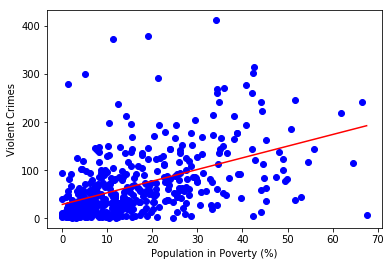

In [10]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Population in Poverty (%)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 3124.8215709690257
R-squared (R2 ): 0.191403330621723


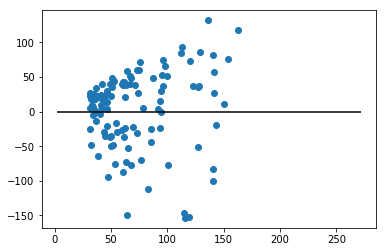

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
#plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
#plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

# =============================================


MSE: 0.6428740623975807, R2: 0.19140333062172288


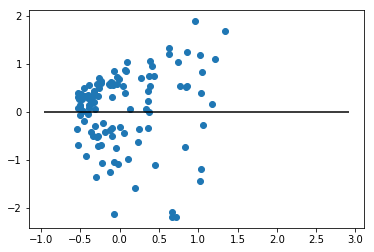

In [12]:
################# SCALING DATA #############

from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

model = LinearRegression()

model.fit(X_train_scaled, y_train_scaled)

y_predictions = model.predict(X_test_scaled)

model.fit(X_train_scaled, y_train_scaled)


plt.scatter(y_predictions, y_predictions - y_test_scaled)
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())

MSE = mean_squared_error(y_test_scaled, y_predictions)
r2 = r2_score(y_test_scaled, y_predictions)
print(f"MSE: {MSE}, R2: {r2}")

#######################################################

### Percent Unemployed x Total Violent Crime

Weight coefficients:  [[2.62371498]]
y-axis intercept:  [42.92295191]


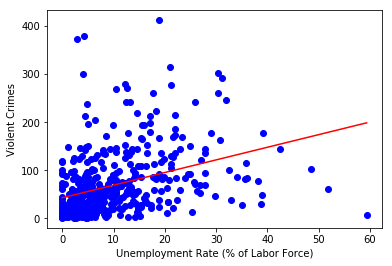

In [13]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Unemployment Rate (% of Labor Force)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 3207.46291847133
R-squared (R2 ): 0.17001858374077594


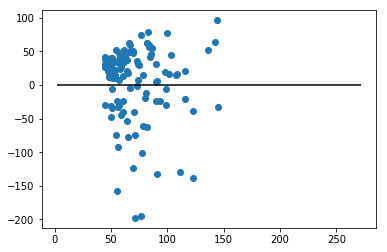

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

# =============================================

### Percent Vacant Units x Total Violent Crime

Weight coefficients:  [[1.68225421]]
y-axis intercept:  [52.19514742]


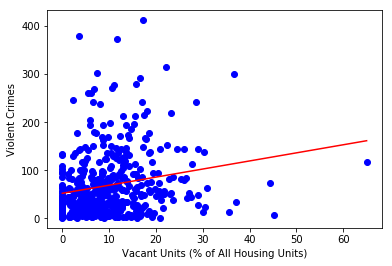

In [15]:
X = merge_table_final.pct_vacancy.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Vacant Units (% of All Housing Units)')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

Mean Squared Error (MSE): 4025.7701841690937
R-squared (R2 ): -0.04173127606516025


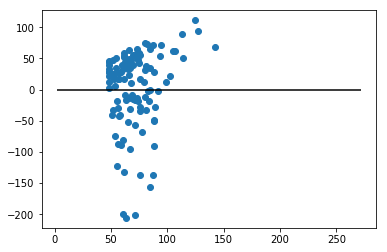

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

# =============================================

---

### Total Population x Total Violent Crime

In [ ]:
X = merge_table_final.total_pop.values.reshape(-1, 1)
y = merge_table_final.Total_Violent_Crime.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### Percent Poverty x ADW

In [ ]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

In [ ]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Robbery.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

In [ ]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Sex_Abuse.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

In [ ]:
X = merge_table_final.pct_poverty.values.reshape(-1, 1)
y = merge_table_final.Homicide.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

In [ ]:
X = merge_table_final.pct_unemployed.values.reshape(-1, 1)
y = merge_table_final.ADW.values.reshape(-1, 1)

model = LinearRegression()

model.fit(X, y)

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])

y_min = model.predict(x_min)
y_max = model.predict(x_max)

plt.scatter(X, y, c='blue')
plt.xlabel('Block Group Population')
plt.ylabel('Violent Crimes')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
                                                    
model = LinearRegression()

model.fit(X_train, y_train)

y_predictions = model.predict(X_test)

plt.scatter(y_predictions, y_predictions - y_test)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")